In [1]:
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

<h1><center>General Configurations</center></h1>

In [40]:
data_dir = './sartorius-cell-instance-segmentation'
BATCH_SIZE = 2
NUM_EPOCHS = 5

TRAIN_CSV = f"{data_dir}/train.csv"
TRAIN_PATH = f"{data_dir}/train"
TEST_PATH = f"{data_dir}/test"
annFile_path = f"{data_dir}/annotations_train.json"

ROOT = Path(data_dir)
TRAIN_PATH_ = Path(TRAIN_PATH)

WIDTH = 704
HEIGHT = 520
# Threshold for mask length
TH = 40
BATCH_SIZE = 2
LR = 1e-3
WEIGHT_DECAY = 0.0005


# Normalize to resnet mean and std if True.
RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]
IMAGE_RESIZE = (224, 224)


In [38]:
TRAIN_FILES = sorted(list(Path(TRAIN_PATH).rglob('*png')))
# annFile = Path(annFile_path)
# coco = COCO(annFile)
# imgIds = coco.getImgIds()
# imgs = coco.loadImgs(imgIds[-3:])

In [ ]:
# dataDir=Path('./sartorius-cell-instance-segmentation')

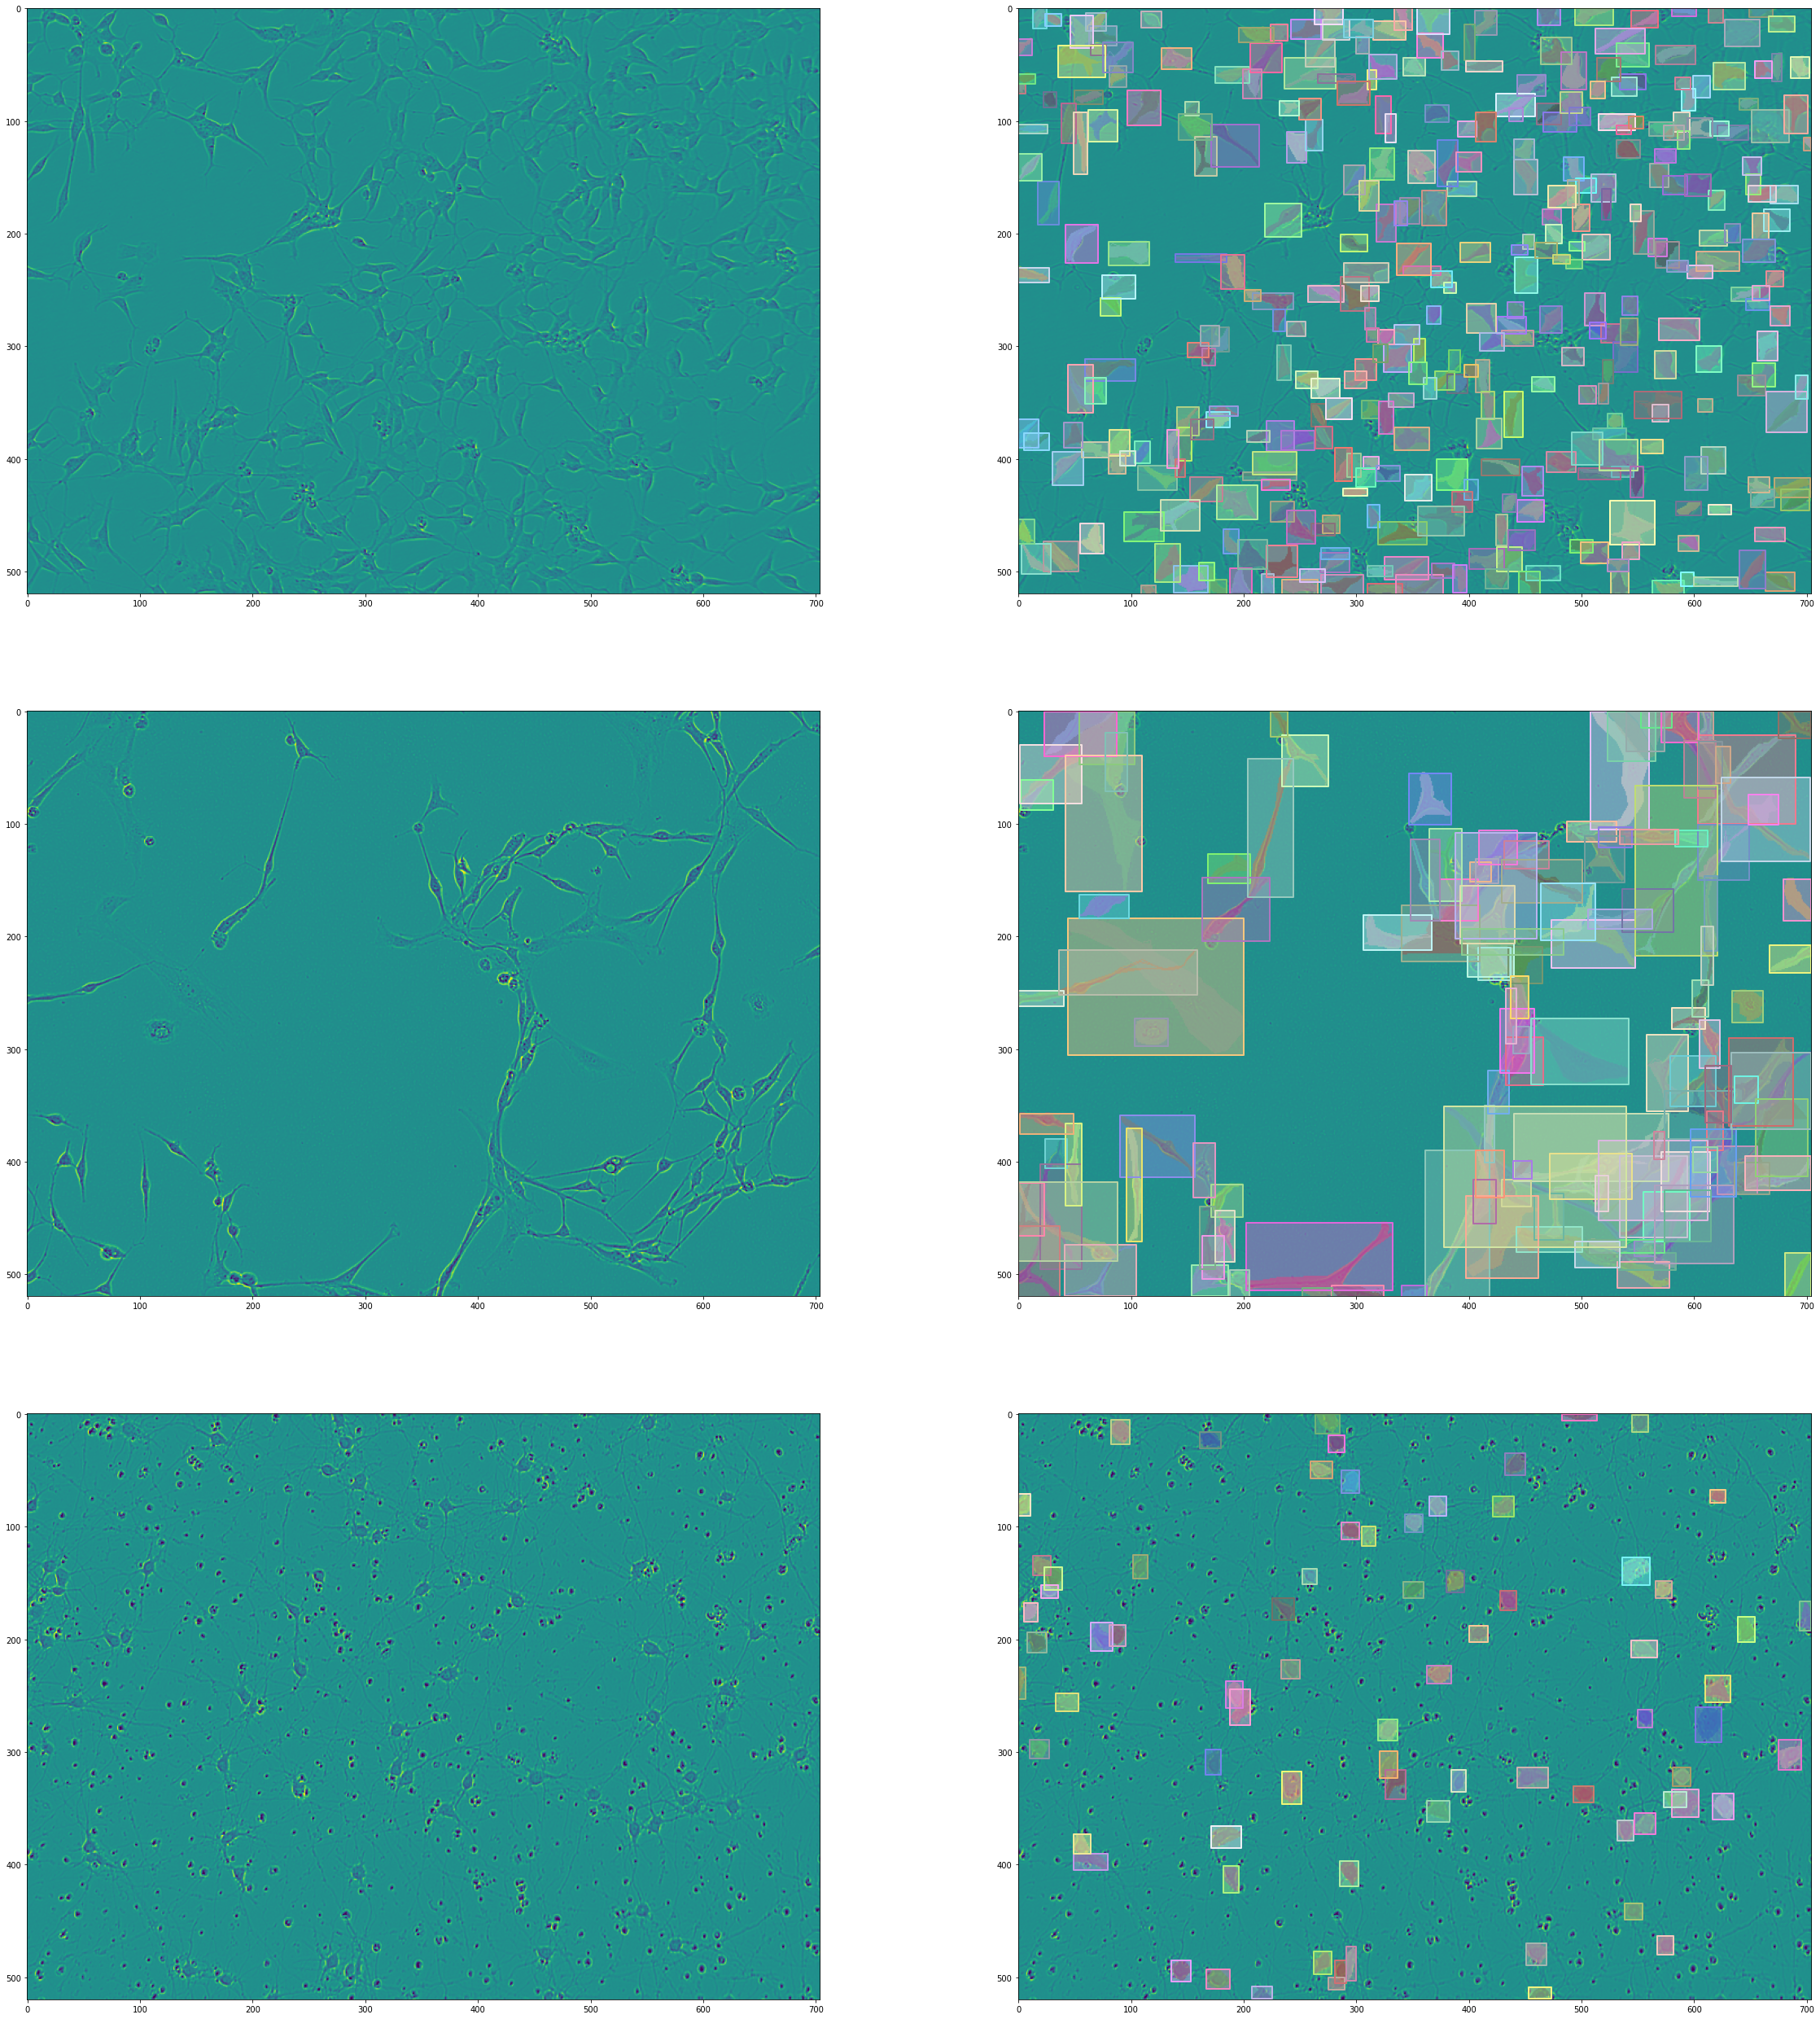

In [36]:
# imgs = coco.loadImgs(imgIds[-3:])
# _,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
# for img, ax in zip(imgs, axs):
#     I = io.imread(dataDir/img['file_name'])
#     annIds = coco.getAnnIds(imgIds=[img['id']])
#     anns = coco.loadAnns(annIds)
#     ax[0].imshow(I)
#     ax[1].imshow(I)
#     plt.sca(ax[1])
#     coco.showAnns(anns, draw_bbox=True)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.filters import threshold_otsu
import scipy.ndimage as ndi

from tqdm.notebook import tqdm
from pycocotools import mask as maskUtils
from joblib import Parallel, delayed

In [6]:
df = pd.read_csv(TRAIN_CSV)

In [7]:
def clean_mask(mask):
    '''
    Function is called to identify whether the mask is broken
    returns True or False state and also returns a mask
    '''
    mask = mask > threshold_otsu(np.array(mask).astype(np.uint8))
    mask = ndi.binary_fill_holes(mask).astype(np.uint8)
    
    # New code for mask acceptance
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c = contours[0][:, 0]
    diff = c - np.roll(c, 1, 0)
    # find horizontal lines longer than threshold
    targets = (diff[:, 1] == 0) & (np.abs(diff[:, 0]) >= TH)  
    
    return mask, (True in targets)

In [8]:
def rle2mask(rle, img_w, img_h):

    '''Function decodes rle (for sartorius comp) to
    binary mask'''

    array = np.fromiter(rle.split(), dtype=np.uint)
    array = array.reshape((-1, 2)).T
    array[0] = array[0] - 1

    ## decompressing the rle encoding (ie, turning [3, 1, 10, 2] into [3, 4, 10, 11, 12])
    # for faster mask construction

    starts, lenghts = array
    mask_decompressed = np.concatenate([np.arange(s, s + l, dtype=np.uint) for s, l in zip(starts, lenghts)])
    ## Building the binary mask
    msk_img = np.zeros(img_w * img_h, dtype=np.uint8)
    msk_img[mask_decompressed] = 1
    msk_img = msk_img.reshape((img_h, img_w))
    msk_img, broken_mask = clean_mask(msk_img)
    if broken_mask:
        broken_zero = np.zeros_like(msk_img)
        return np.asfortranarray(broken_zero)
    msk_img = np.asfortranarray(msk_img)  ## This is important so pycocotools can handle this object

    return msk_img

189036 1 189739 3 190441 6 191144 7 191848 8 192552 9 193256 10 193960 11 194664 11 195368 12 196072 12 196776 13 197480 13 198185 13 198889 13 199593 14 200297 13 201002 11 201706 10 202410 9 203115 7 203819 6 204523 5 205227 5 205932 3 206636 2 207340 1


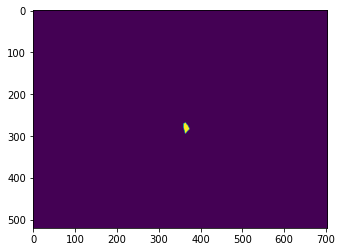

In [9]:
rle = df.loc[1, 'annotation']
print(rle)
plt.imshow(rle2mask(rle, 704, 520));

In [10]:
def build_mask(labels, input_shape, colors=False):
    height, width = input_shape
    masks = np.zeros((width,height))
    #masks = np.zeros((height,width), dtype=np.uint8)
    for i, label in enumerate(labels):
        a_mask = rle2mask(label, height,width)
        a_mask = np.array(a_mask) > 0 
# #         a_mask, broken_mask = clean_mask(a_mask)
# #         if broken_mask:
# #             continue
        masks += a_mask
#     masks = masks.clip(0,1)
    return masks

In [11]:
df_tr = df[df['id']=='0140b3c8f445'].reset_index(drop=True)

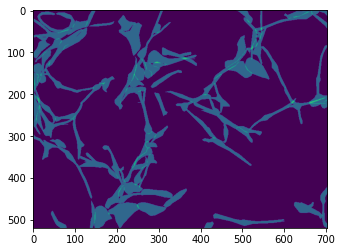

In [12]:
sample_masks1 = build_mask(df_tr['annotation'],(704, 520))
plt.imshow(sample_masks1)

In [13]:
def annotate(idx,row,cat_ids):
    '''
    Function is called to build json file
    '''
    
    # Binary mask
    mask = rle2mask(row['annotation'], row['width'], row['height']) 
    # Encoding it back to rle (coco format)
    c_rle = maskUtils.encode(mask) 
    # converting from binary to utf-8
    c_rle['counts'] = c_rle['counts'].decode('utf-8') 
    # calculating the area
    area = maskUtils.area(c_rle).item()
    # calculating the bboxes
    bbox = maskUtils.toBbox(c_rle).astype(int).tolist() 
    annotation = {
            'segmentation': c_rle,
            'bbox': bbox,
            'area': area,
            'image_id':row['id'], 
            'category_id':cat_ids[row['cell_type']], 
            'iscrowd':0, 
            'id':idx
        }
    return annotation

In [22]:
def coco_structure(df, workers = 2):
    
    ## Building the header
    cat_ids = {name:id+1 for id, name in enumerate(df.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'{id}.png'} for id,row in df.groupby('id').agg('first').iterrows()]
    
    ## Building the annotations
    annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(df.iterrows(), total = len(df)))
        
    return {'categories':cats, 'images':images, 'annotations':annotations}

In [23]:
import json,itertools
root = coco_structure(df)

  0%|          | 0/73585 [00:00<?, ?it/s]

In [24]:
with open('annotations_train.json', 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

In [25]:
TRAIN_FILES = sorted(list(Path(TRAIN_PATH).rglob('*png')))
annFile = Path(annFile_path)
coco = COCO(annFile)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


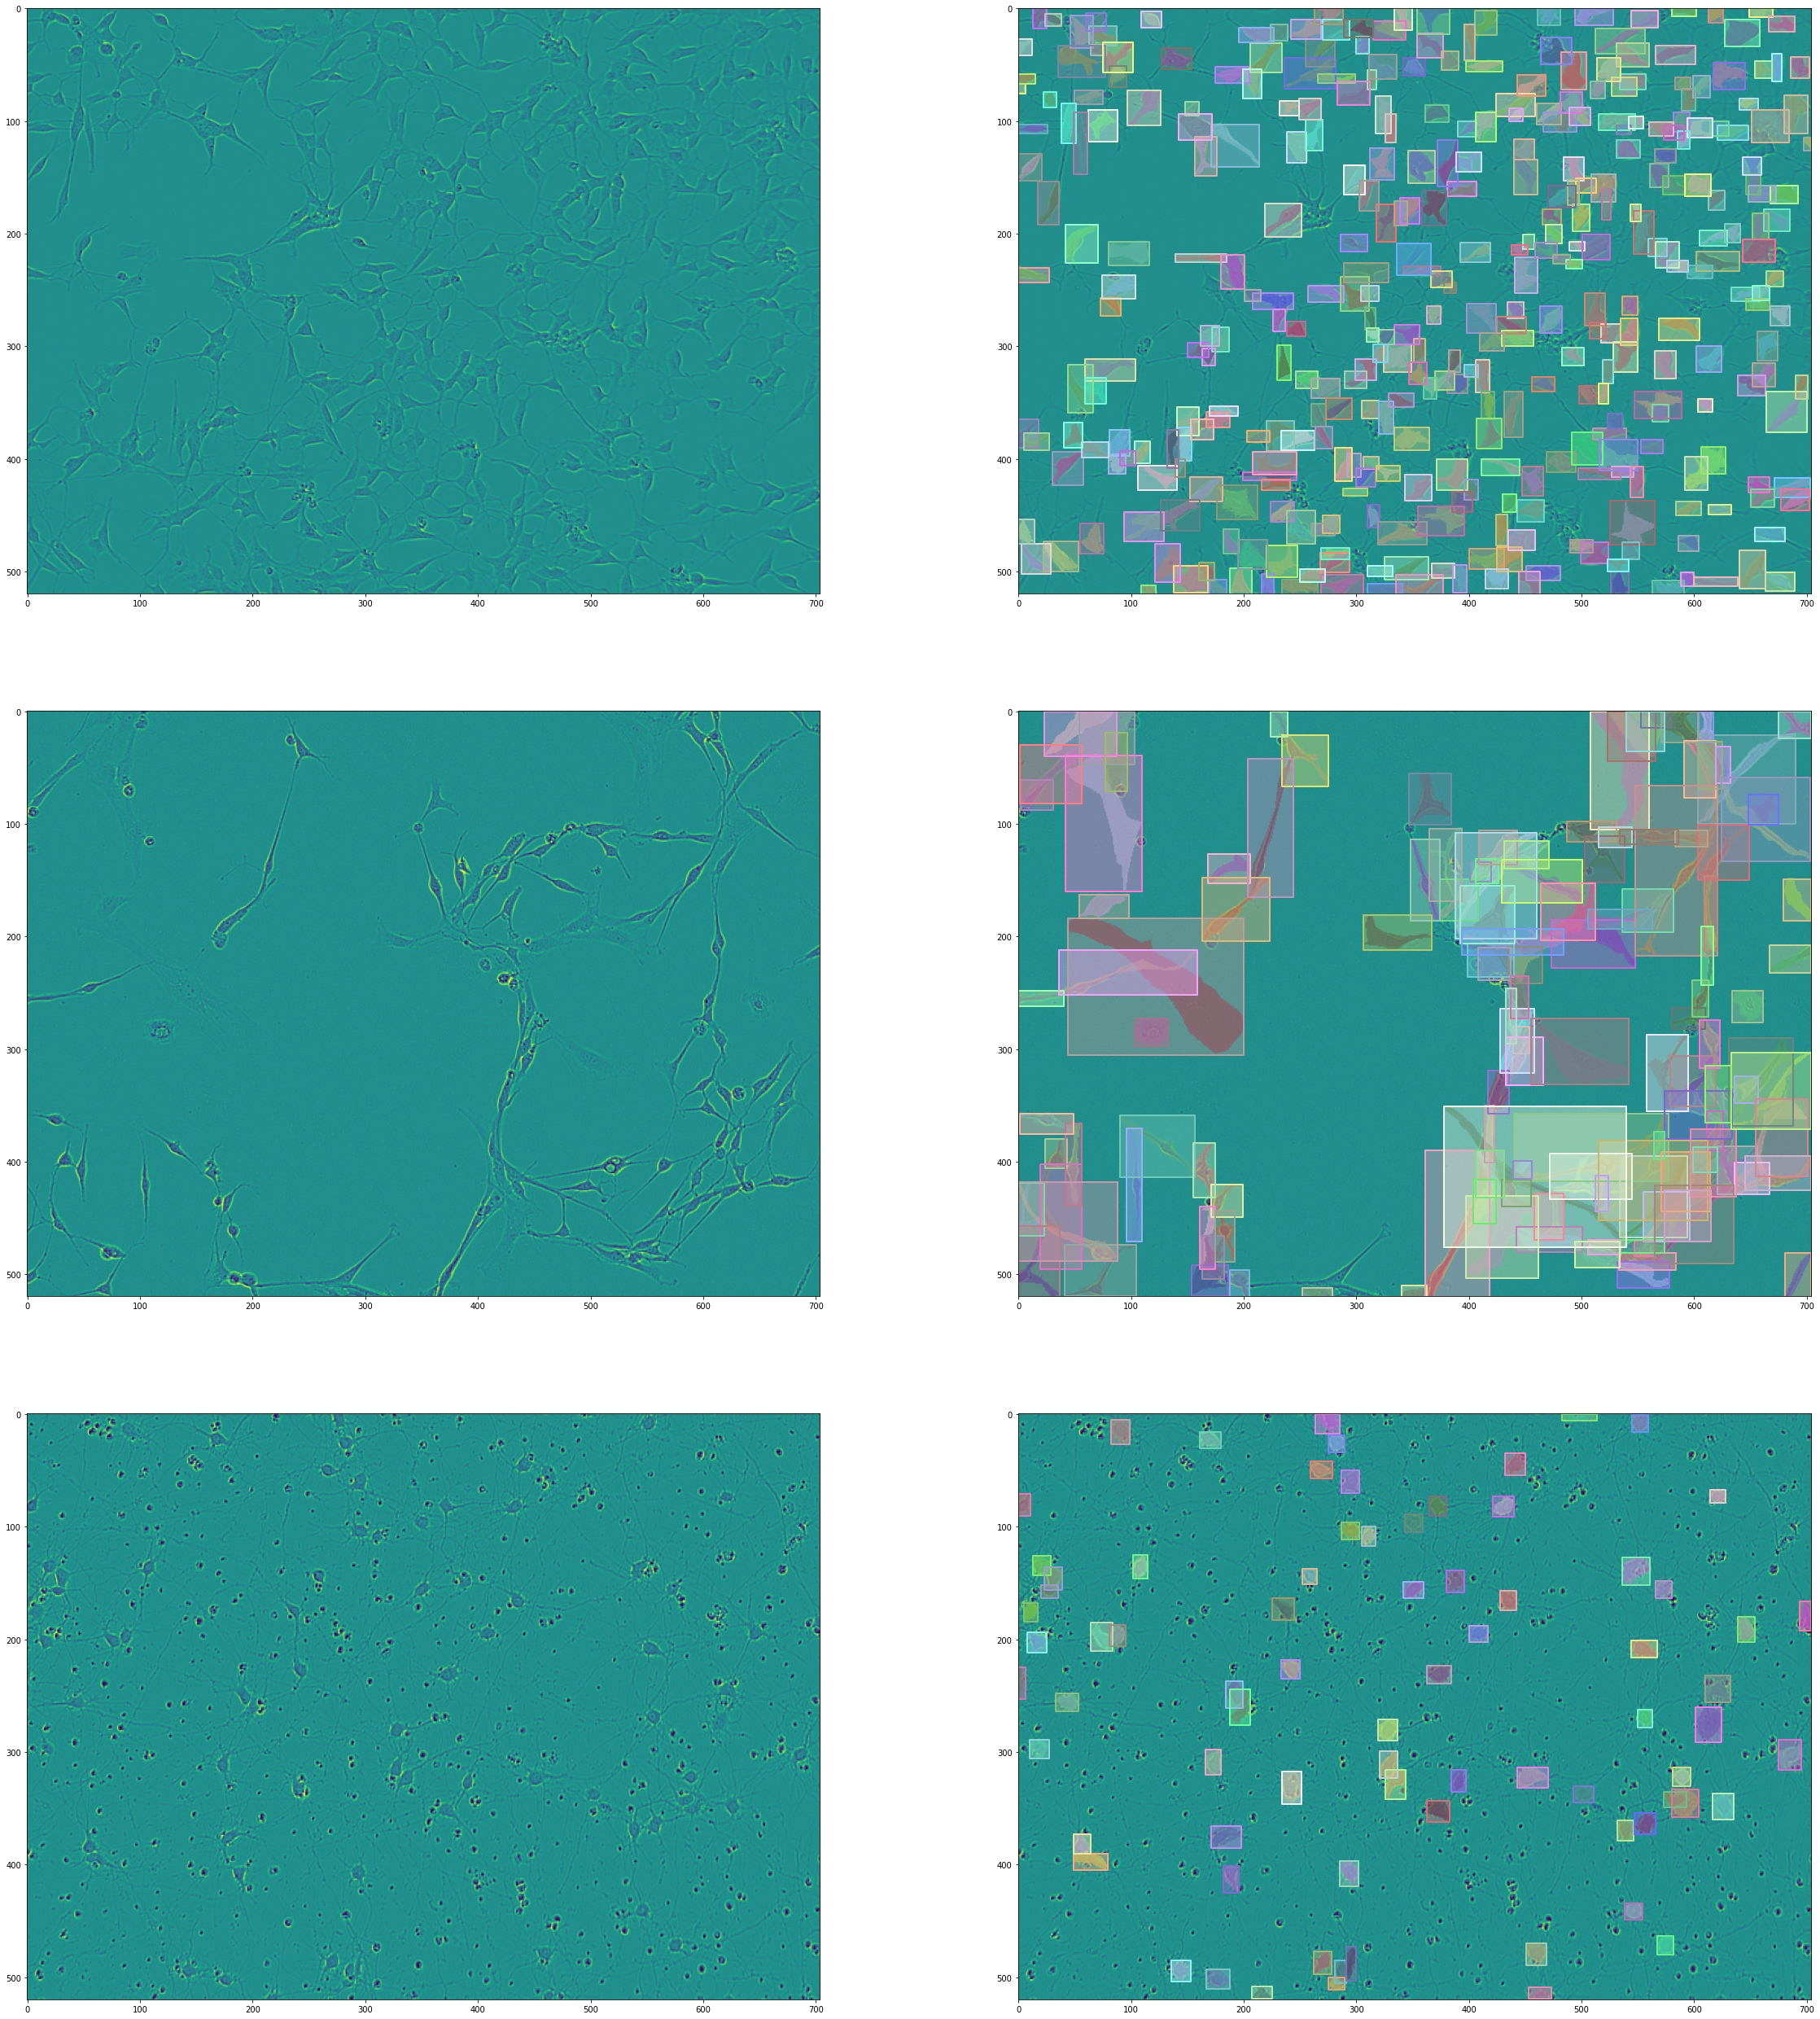

In [41]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = io.imread(TRAIN_PATH_/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)